In [1]:
import pandas as pd
import numpy as np
from GlassBox.figs.figs_utils import FIGSGridSearch
from imodels import FIGSClassifier
%reload_ext autoreload
%autoreload 2

# Grid-search

In [2]:
FIGS_parameter = dict(
    max_rules= [5,10,15,20,25],
    max_trees=[2,3,4,5,6,7,8,9,10],
    min_impurity_decrease=[0.1, 0.2, 0.3],
)

gs = FIGSGridSearch(path_dataset="../../outputs/scores.csv", task="Classifier", random_state=841)
best_ = gs.grid_search(FIGSModel=FIGSClassifier, hyperparameters=FIGS_parameter)
gs.save_model_parameters(best_[0],best_[1], name="model_classifier")

100%|██████████| 135/135 [07:37<00:00,  3.39s/it, nDCG=0.623]


# Metric evalutation

In [10]:
best_model, parameters = gs.load_model_parameters(name="model_classifier")
best_model,parameters

(FIGSClassifier(max_rules=5, max_trees=2, min_impurity_decrease=0.1),
 {'max_rules': 5, 'max_trees': 2, 'min_impurity_decrease': 0.1})

In [11]:
# nDCG on test-set
nDCG_train = gs.eval_model(model=best_model, df=gs.train, nDCG_at=[1,10,15])
nDCG_valid = gs.eval_model(model=best_model, df=gs.valid, nDCG_at=[1,10,15])
nDCG_test = gs.eval_model(model=best_model, df=gs.test, nDCG_at=[1,10,15])

display(pd.DataFrame([nDCG_train,nDCG_valid,nDCG_test],index=["Training","Validation","Test"]))

,nDCG@1,nDCG@10,nDCG@15
Training,0.5358,0.5966,0.6060
Validation,0.5667,0.6167,0.6233
Test,0.5370,0.5988,0.6087


## Example of Job-offer

In [5]:
qId = 1
job_curricula = gs.test[gs.test["qId"] == qId]

y_pred = best_model.predict(np.asarray(job_curricula.iloc[:, 2:13]))

y_pred = pd.DataFrame(y_pred, index=job_curricula.index, columns=["lambdas"])
dt_final = pd.merge(job_curricula, y_pred, left_index=True, right_index=True)

In [6]:
dt_final.sort_values("labels", ascending=False)["labels"].head(15)

791     4
1496    4
1224    3
955     3
1338    3
968     3
1086    3
1269    3
877     3
1120    3
790     3
1018    3
1401    3
945     3
1118    3
Name: labels, dtype: int64

In [7]:
dt_final.sort_values("lambdas",ascending=False)["labels"].head(15)

957     2
788     2
1121    1
767     2
1295    2
1430    2
954     2
966     2
857     2
1347    2
1452    3
1110    2
1116    1
1276    2
1286    2
Name: labels, dtype: int64

In [8]:
print(best_model)

> ------------------------------
> FIGS-Fast Interpretable Greedy-Tree Sums:
> 	Predictions are made by summing the "Val" reached by traversing each tree.
> 	For classifiers, a sigmoid function is then applied to the sum.
> ------------------------------
Skills <= 0.292 (Tree #0 root)
	Education <= 0.900 (split)
		Val: 1.811 (leaf)
		Salary <= 0.900 (split)
			Val: 1.912 (leaf)
			Val: 2.012 (leaf)
	Val: 2.581 (leaf)

	+
Language <= 0.475 (Tree #1 root)
	Age <= 0.500 (split)
		Val: -0.128 (leaf)
		Val: 0.008 (leaf)
	Val: 0.252 (leaf)


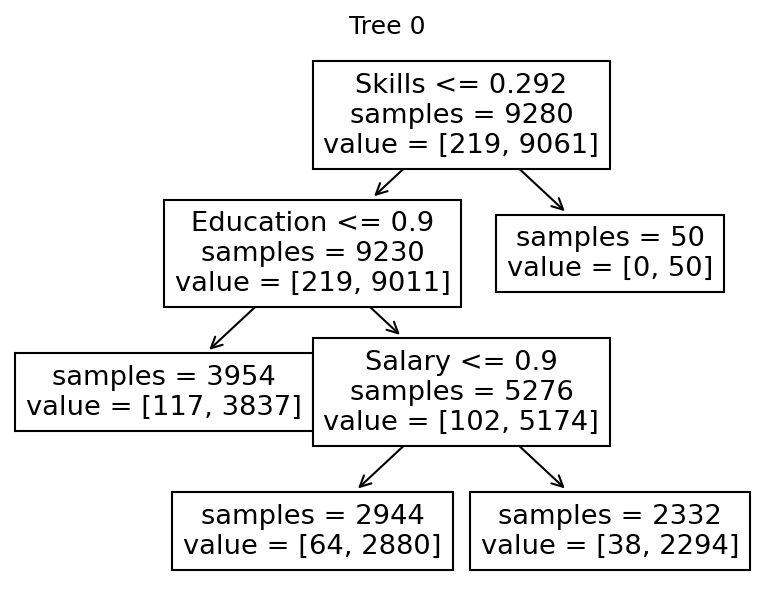

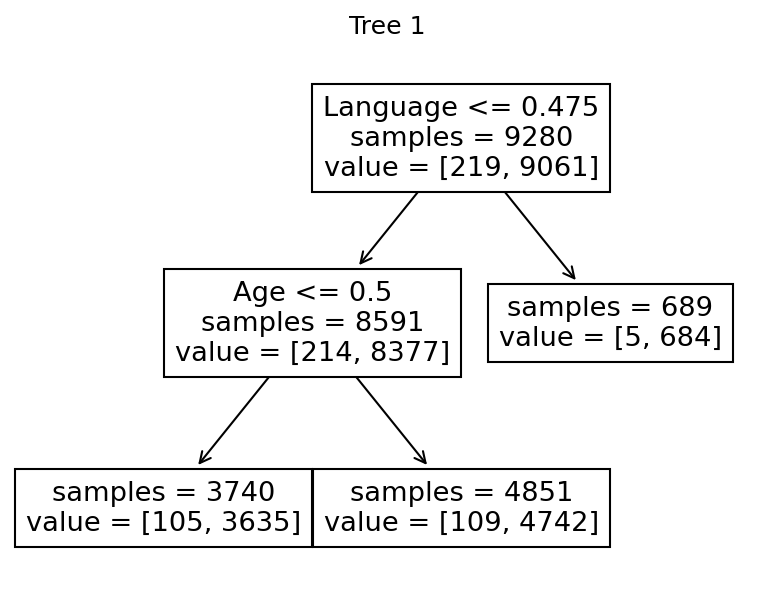

In [9]:
for i in range(len(best_model.trees_)):
    best_model.plot(feature_names=gs.feature_name,  tree_number=i)  